In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorboard.backend.event_processing import event_accumulator

# Read the training curves from the tensorboard events files
def read_tensorboard_events(event_file):
    # Load the event data
    ea = event_accumulator.EventAccumulator(
        event_file,
        size_guidance={event_accumulator.SCALARS: 0}  # Load all scalar data
    )
    ea.Reload()
    # List available scalar tags to find your reward tag
    print("Available scalar tags:", ea.Tags().get('scalars', []))

    # Extract reward events (replace 'reward' with your actual tag name)
    tag = 'charts/episodic_return'
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    # Create a DataFrame for easier handling
    return pd.DataFrame({"Step": steps, "Value": values})

ppo_csv = read_tensorboard_events('runs/Humanoid-v4__ppo_continuous_action__1__1746105570/events.out.tfevents.1746105570.falcon.4144941.0')
sam_ppo_csv = read_tensorboard_events('runs/Humanoid-v4__ppo_continuous_action_sam__1__1746105579/events.out.tfevents.1746105579.falcon.4145047.0')
# ppo_csv = read_tensorboard_events('runs/Ant-v4__ppo_continuous_action__2__1746841041/events.out.tfevents.1746841041.falcon.304077.0')
# sam_ppo_csv = read_tensorboard_events('runs/Ant-v4__ppo_continuous_action_sam__rho0.01__2__1746885815/events.out.tfevents.1746885815.falcon.350647.0')


Available scalar tags: ['charts/episodic_return', 'charts/episodic_length', 'charts/learning_rate', 'losses/value_loss', 'losses/policy_loss', 'losses/entropy', 'losses/old_approx_kl', 'losses/approx_kl', 'losses/clipfrac', 'losses/explained_variance', 'charts/SPS', 'eval/episodic_return']
Available scalar tags: ['charts/episodic_return', 'charts/episodic_length', 'charts/learning_rate', 'losses/value_loss', 'losses/policy_loss', 'losses/entropy', 'losses/old_approx_kl', 'losses/approx_kl', 'losses/clipfrac', 'losses/explained_variance', 'charts/SPS', 'eval/episodic_return']


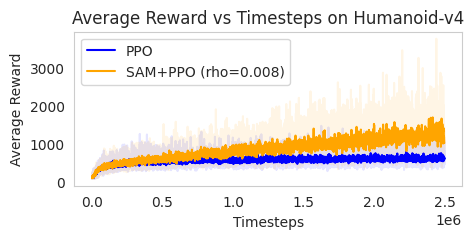

In [8]:

# Ge the smoothed values
ppo_values = ppo_csv["Value"].values
sam_ppo_values = sam_ppo_csv["Value"].values
ppo_smooth_avg = ppo_csv["Value"].rolling(window=10).mean()
sam_ppo_smooth_avg = sam_ppo_csv["Value"].rolling(window=10).mean()
ppo_smooth_std = ppo_csv["Value"].rolling(window=10).std()
sam_ppo_smooth_std = sam_ppo_csv["Value"].rolling(window=10).std()

# Plot the reward curves with smoothing using seaborn
plt.figure(figsize=(5, 2))
sns.set_style("whitegrid")
sns.lineplot(x=ppo_csv["Step"], y=ppo_values, color="blue", alpha=0.1)
sns.lineplot(x=sam_ppo_csv["Step"], y=sam_ppo_values, color="orange", alpha=0.1)
sns.lineplot(x=ppo_csv["Step"], y=ppo_smooth_avg, label="PPO", color="blue")
sns.lineplot(x=sam_ppo_csv["Step"], y=sam_ppo_smooth_avg, label="SAM+PPO (rho=0.008)", color="orange")
# plt.fill_between(ppo_csv["Step"], ppo_smooth_avg - ppo_smooth_std, ppo_smooth_avg + ppo_smooth_std, color="blue", alpha=0.2)
# plt.fill_between(sam_ppo_csv["Step"], sam_ppo_smooth_avg - sam_ppo_smooth_std, sam_ppo_smooth_avg + sam_ppo_smooth_std, color="orange", alpha=0.2)
plt.xlabel("Timesteps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Timesteps on Humanoid-v4")
plt.legend()
plt.grid()
# plt.savefig("ppo_vs_sam_ppo.png")
plt.show()

In [29]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(x)
    
def make_env(env_id, idx, capture_video, run_name, gamma):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        env = gym.wrappers.NormalizeObservation(env)
        env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
        env = gym.wrappers.NormalizeReward(env, gamma=gamma)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))
        return env

    return thunk

env_id = "Ant-v4"
capture_video = False
run_name = "ppo_vs_sam_ppo"
gamma = 0.99
sam_rho = 0.008
device = torch.device("cpu")

run_name = 'Ant-v4__ppo_continuous_action__2__1746841041'
exp_name = run_name.split("__")[1]
env_id = run_name.split("__")[0]
seed = int(run_name.split("__")[2])
time = run_name.split("__")[3]
sam_append = f"__rho{sam_rho}" if "sam" in exp_name else ""

model_path = f"runs/{run_name}/{exp_name}.cleanrl_model"

Model = Agent
envs = gym.vector.SyncVectorEnv([make_env(env_id, 0, capture_video, run_name, gamma)])
agent = Model(envs).to(device)
agent.load_state_dict(torch.load(model_path, map_location=device))
agent.eval()

print(envs.envs[0].unwrapped.model.geom('floor'))
print(envs.envs[0].unwrapped.model.geom('floor').id)
print(envs.envs[0].unwrapped.model.geom('floor').friction)
# print(envs.envs[0].unwrapped.model.body('left_foot'))
# print(envs.envs[0].unwrapped.model.body('left_foot').mass)
# print(envs.envs[0].unwrapped.model.body_mass)
print(envs.envs[0].unwrapped.model.geom_bodyid)
print(envs.envs[0].unwrapped.model.geom_friction)
# geom_id = envs.envs[0].unwrapped.model.geom('floor').id
# envs.envs[0].unwrapped.model.geom_friction[geom_id] = np.array([0.1, 0.1, 0.1])
print(envs.envs[0].unwrapped.model.geom_friction)
print(envs.envs[0].unwrapped.model.geom('floor'))


<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1. , 0.5, 0.5])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 0
  margin: array([0.01])
  matid: array([0], dtype=int32)
  name: 'floor'
  pos: array([0., 0., 0.])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.])
  rgba: array([0.8, 0.9, 0.8, 1. ], dtype=float32)
  sameframe: array([1], dtype=uint8)
  size: array([40., 40., 40.])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([0], dtype=int32)
  user: array([], dtype=float64)
>
0
[1.  0.5 0.5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[[1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.

In [30]:


# rollout the agent
obs, _ = envs.reset(seed=np.random.randint(1000))
print(envs.envs[0].unwrapped.model.geom_friction)
print(envs.envs[0].unwrapped.model.geom('floor'))
end = False
while not end:
    actions, _, _, _ = agent.get_action_and_value(torch.Tensor(obs).to(device))
    next_obs, _, _, _, infos = envs.step(actions.cpu().numpy())
    if "final_info" in infos:
        for info in infos["final_info"]:
            if "episode" in info:
                avg_reward = info["episode"]["r"]
                print(f"Episode finished with average reward: {avg_reward}")
                end = True
                break
    obs = next_obs
# Save the video


[[1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]
 [1.  0.5 0.5]]
<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1. , 0.5, 0.5])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 0
  margin: array([0.01])
  matid: array([0], dtype=int32)
  name: 'floor'
  pos: array([0., 0., 0.])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.])
  rgba: array([0.8, 0.9, 0.8, 1. ], dtype=float32)
  sameframe: array([1], dtype=uint8)
  size: array([40., 40., 40.])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([0], dtype=int32)
  user: array([], dtype=float64)
>
Episode

In [ ]:

# ppo_csv = pd.read_csv("./results/Humanoid-v4__ppo_continuous_action__1__1746105570.csv")
# sam_ppo_csv = pd.read_csv("./results/Humanoid-v4__ppo_continuous_action_sam__1__1746105579.csv")


# print(ppo_csv.head())
# print(sam_ppo_csv.head())

# # Plot the reward curves
# plt.figure(figsize=(10, 5))
# plt.plot(ppo_csv["Step"], ppo_csv["Value"], label="PPO", color="blue")
# plt.plot(sam_ppo_csv["Step"], sam_ppo_csv["Value"], label="SAM-PPO", color="orange")
# plt.xlabel("Timesteps")
# plt.ylabel("Average Reward")
# plt.title("Average Reward vs Timesteps")
# plt.legend()
# plt.grid()
# # plt.savefig("ppo_vs_sam_ppo.png")
# plt.show()